In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [2]:
# --- Paths ---
# This is the folder containing all your new .wav files
RAW_DATA_DIR = 'data/murmur_dataset_v1' 
# Where we will save our new, clean spectrograms
PROCESSED_DATA_DIR = 'processed_data'

# --- Audio Settings ---
TARGET_SR = 4000
TARGET_DURATION = 5

In [3]:
file_metadata = []

# Loop through every file in our raw data directory
for filename in os.listdir(RAW_DATA_DIR):
    if filename.endswith('.wav'):
        # Split the filename into its parts
        parts = filename.replace('.wav', '').split('_')
        
        # Ensure the filename has the expected structure
        if len(parts) == 4:
            disease, patient_id, position, area = parts
            file_path = os.path.join(RAW_DATA_DIR, filename)
            
            file_metadata.append({
                'filepath': file_path,
                'disease_class': disease,
                'patient_id': patient_id,
                'position': position,
                'area': area
            })

# Create a rich DataFrame from our extracted metadata
files_df = pd.DataFrame(file_metadata)

print(f"Successfully parsed {len(files_df)} audio files.")
print("\nHere's a sample of the rich metadata we extracted:")
print(files_df.head())

print("\nDistribution of Heart Conditions:")
print(files_df['disease_class'].value_counts())

Successfully parsed 464 audio files.

Here's a sample of the rich metadata we extracted:
                                    filepath disease_class patient_id  \
0  data/murmur_dataset_v1/MS_006_sit_Pul.wav            MS        006   
1   data/murmur_dataset_v1/N_094_sit_Pul.wav             N        094   
2   data/murmur_dataset_v1/N_098_sup_Tri.wav             N        098   
3   data/murmur_dataset_v1/N_107_sup_Tri.wav             N        107   
4   data/murmur_dataset_v1/N_089_sup_Aor.wav             N        089   

  position area  
0      sit  Pul  
1      sit  Pul  
2      sup  Tri  
3      sup  Tri  
4      sup  Aor  

Distribution of Heart Conditions:
disease_class
N     168
MS     88
MR     88
AS     64
AR     56
Name: count, dtype: int64


In [4]:
# --- Define a new directory for our CQT data ---
PROCESSED_DATA_DIR = 'processed_data_cqt'

# Create the output directory if it doesn't exist
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

print("\nStarting preprocessing with Constant-Q Transform (CQT)...")

# Loop through our DataFrame
for index, row in tqdm(files_df.iterrows(), total=files_df.shape[0]):
    input_path = row['filepath']
    label = row['disease_class']
    
    output_filename = f"{label}-{row['patient_id']}-{row['position']}-{row['area']}.npy"
    output_path = os.path.join(PROCESSED_DATA_DIR, output_filename)
    
    try:
        # 1. Load and Resample
        audio, sr = librosa.load(input_path, sr=TARGET_SR, mono=True)
        
        # 2. Standardize Length
        target_samples = TARGET_SR * TARGET_DURATION
        if len(audio) > target_samples:
            audio = audio[:target_samples]
        else:
            audio = np.pad(audio, (0, target_samples - len(audio)), 'constant')
        
        # --- SAFETY CHECK for silent audio ---
        if np.max(np.abs(audio)) == 0:
            print(f"Skipping silent file: {input_path}")
            continue

        # 3. --- THE FIX IS HERE ---
        # Create the Constant-Q Transform with parameters that respect the Nyquist frequency.
        # We set a realistic minimum frequency (fmin) and reduce the number of bins.
        cqt = librosa.cqt(y=audio, sr=sr, 
                          fmin=librosa.note_to_hz('C1'), # Start at a low freq (~32 Hz)
                          n_bins=60) # Use fewer bins to prevent exceeding Nyquist

        cqt_db = librosa.amplitude_to_db(np.abs(cqt))

        # 4. Normalize the CQT image
        def normalize(S):
            return (S - S.min()) / (S.max() - S.min() + 1e-6)

        final_cqt = normalize(cqt_db)

        # 5. Save the new CQT data
        np.save(output_path, final_cqt)

    except Exception as e:
        # This will now only catch very unexpected errors
        print(f"A critical error occurred with file {input_path}: {e}")

print("\nPreprocessing complete!")


Starting preprocessing with Constant-Q Transform (CQT)...


  0%|          | 0/464 [00:00<?, ?it/s]


Preprocessing complete!


Successfully created 464 processed files.

Shape of the processed CQT data: (60, 40)
This means (Height, Width).


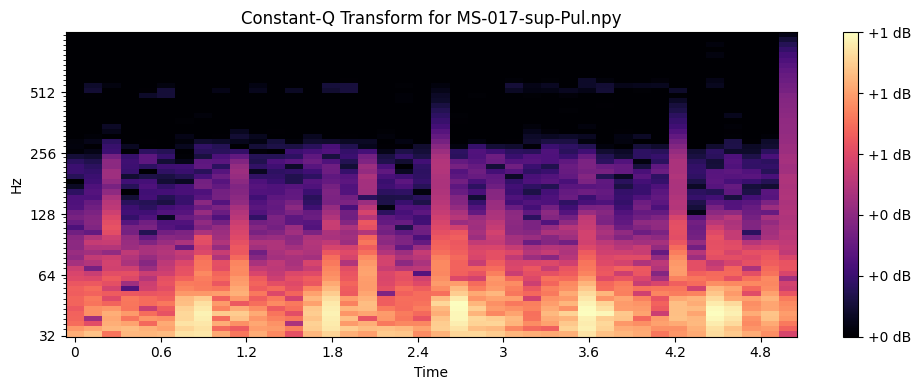

In [6]:
# Get a list of the new files we created
processed_files = os.listdir(PROCESSED_DATA_DIR)
print(f"Successfully created {len(processed_files)} processed files.")

# --- SAFETY CHECK ---
if len(processed_files) > 0:
    # Load one of the new files to see what it looks like
    example_processed_file = np.load(os.path.join(PROCESSED_DATA_DIR, processed_files[0]))

    print(f"\nShape of the processed CQT data: {example_processed_file.shape}")
    print("This means (Height, Width).")

    # --- THE FIX IS HERE ---
    # Display the 2D CQT data directly. No need to index a 3rd dimension.
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(example_processed_file,
                             sr=TARGET_SR,
                             x_axis='time',
                             y_axis='cqt_hz') # Use 'cqt_hz' for a CQT plot
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Constant-Q Transform for {processed_files[0]}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo files were processed. Please check the output of the cell above for errors.")